In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product as prd

In [3]:
a = np.array([[3, 0], [0, 0]])
a.shape

(2, 2)

In [38]:
class Constraints(object):
    """This is the main class to produce a set of constraints for ROs"""
    def __init__(self, first_instance_names = 'design_1_i/LUT6_RO_0/inst/Inverter/LUT6_inst' \
                 ,other_instance_names = 'design_1_i/LUT6_RO_0/inst/notGates[@inst].Inverter/LUT6_inst'\
                 , max_loop1 = 1, max_loop2 = 1\
                 , num_stages = 3, shape = np.array([[3, 0], [0, 0]]).astype(int), lut_type = 'ALL', start_location = (0,0)):
        self.first_instance_names = first_instance_names
        self.other_instance_names = other_instance_names
        self.max_loop1 = max_loop1
        self.max_loop2 = max_loop2
        self.num_ROs = num_stages
        self.shape = shape.astype(int) #num Slices in x * y
        self.lut_type = lut_type # A, B, C, D, All
        self.start_location = start_location #{generic_name : [num_RO, num_stages, location_tuple]} ; location_tuple = (x1, y1, x2, y2)
        self.data_dict = {'x':[], 'y':[],'A':[],'B':[],'C':[],'D':[]}
        self._outputfile = "constraints"
        assert self.shape.sum() == num_stages
    def RO_location(self):
        """For location constraints"""
        lut_types = ['A', 'B', 'C', 'D']
        ROs = self.num_ROs
        str1 = 'set_property BEL '
        str2 = '6LUT [get_cells '
        str4 = 'set_property LOC SLICE_'
        with open(self._outputfile + ".XDC", "a") as file:
            for i in range(self.shape.shape[0]):
                x = self.start_location[0] + i
                for j in range(self.shape.shape[1]):
                    y = self.start_location[1] + j
                    self.data_dict['x'].append(x)
                    self.data_dict['y'].append(y)
                    self.data_dict['A'].append(0)
                    self.data_dict['B'].append(0)
                    self.data_dict['C'].append(0)
                    self.data_dict['D'].append(0)
                    while self.shape[i][j] > 0:
                        self.shape[i][j] -= 1
                        ROs -= 1
                        if len(self.first_instance_names) > 1:
                            if ROs == 0:
                                str3 = self.first_instance_names + ']'
                            else:
                                str3 = '{' + self.other_instance_names.replace('@inst1', str((ROs-1) //\
                                        self.max_loop1)).replace('@inst2', str((ROs-1) % self.max_loop1))+ '}' + ']'
                        else:
                            str3 = '{' + self.other_instance_names.replace('@inst1', str(ROs //\
                                    self.max_loop1)).replace('@inst2', str((ROs) % self.max_loop1)) + '}' + ']'
                        if 'ALL' in self.lut_type.upper():
                            lut_type = lut_types[self.shape[i][j] % 4]
                        else:
                            lut_type = self.lut_type
                        self.data_dict[lut_type][-1] += 1
                        str5 = f'X{x}Y{y} [get_cells '
                        file.write(str1 + lut_type + str2 + str3 + "\n")
                        file.write(str4 + str5 + str3 + "\n") 
    def loops(self):
        """For combinational loop constraints"""
        with open(self._outputfile + ".XDC", "a") as file:
            file.write("\n")
            for ROs in range(self.num_stages):
                file.write("set_property ALLOW_COMBINATORIAL_LOOPS true [get_nets {" + \
                           self.other_instance_names.replace('@inst1', str(ROs // \
                           self.max_loop1)).replace('@inst2', str(ROs % self.max_loop1)) + '}' + ']'+ "\n")
    def plot(self):
        """Heatmap plot of the locations"""
        key_list = list(self.data_dict.keys())
        for item in key_list:
            if len(self.data_dict[item]) < len(self.data_dict['x']):
                self.data_dict[item] += (len(self.data_dict['x']) - len(self.data_dict[item])) * [0]
        dataframe = pd.DataFrame(self.data_dict)
        dataframe['6LUT'] = dataframe['A'] + dataframe['B'] + dataframe['C'] + dataframe['D']
        for i,j in prd(list(range(35, 60)), list(range(35, 60))):
            if (i,j) not in list(zip(self.data_dict['x'], self.data_dict['y'])):
                df = pd.DataFrame({'x':[i], 'y':[j], 'A':[0], 'B':[0], 'C':[0], 'D':[0], '6LUT':[0]})
                dataframe = dataframe.append(df, ignore_index=True)
        dataframe_long = dataframe.pivot_table(index='x',columns='y',values='6LUT')
        f, ax = plt.subplots(figsize=(9, 6))
        sns.heatmap(dataframe_long, annot=True, fmt="d", linewidths=.5, ax=ax)
        return dataframe

The following will create one RO of five stages in one slice:

In [42]:
arbitrary_shape = 3 * np.kron(np.array([[1, 0, 1, 0],[0, 1, 0, 1],[1, 0, 1, 0],[0, 1, 0, 1]]), np.ones((4,4)))
a = Constraints(first_instance_names = '', \
                   other_instance_names = f'design_1_i/LUT6_RO_0/inst/notGates[@inst1].Inverter/LUT6_inst[@inst2]',\
                   max_loop1 = 16, max_loop2 = 8,num_stages = 384, shape = arbitrary_shape, lut_type = "ALL" , start_location = (35,35))
a.RO_location()

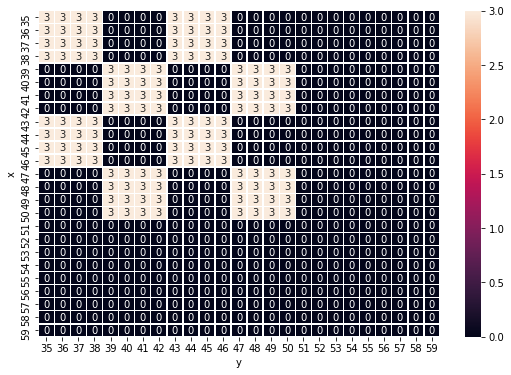

In [43]:
dataframe = a.plot()

In [41]:
np.kron(np.array([[1, 0, 1, 0],[0, 1, 0, 1],[1, 0, 1, 0],[0, 1, 0, 1]]), np.ones((4,4))).sum()*3

384.0

In [24]:
np.ones((3,3))

array([[1., 1.],
       [1., 1.]])

In [75]:
a = zip([1,2,3],[2,3,4])

In [77]:
list(a)

[(1, 2), (2, 3), (3, 4)]